In [16]:
import configparser
import Src.data.dmbioProtDataset as dmbiods
from torch_geometric.data import Data
import Src.model.egnn_clean as eg
import torch
import numpy as np
import networkx as nx
from torch_geometric.utils.convert import to_networkx
import matplotlib.pyplot as plt

In [17]:
config_path = '/teamspace/studios/this_studio/DeepDive/Prot-DNA_experiments/test/testDatasetConfig.ini'
config = configparser.ConfigParser()
config.read(config_path)
config_section = config['DEFAULT']

In [18]:
dsParams = dmbiods.dmbioProtDataSetParams(
    indir = config_section['indir'],
    in_file = config_section['in_file'],
    label_dir = config_section['label_dir'],
    label_fileExt = config_section['label_fileExt'],
    node_feat_dir = config_section['node_feat_dir'],
    node_feat_fileExt = config_section['node_feat_fileExt'],
    edge_dir = config_section['edge_dir'],
    edge_fileExt = config_section['edge_fileExt'],
    node_cord_dir = config_section['node_cord_dir'],
    node_cord_file_ext = config_section['node_cord_file_ext']
)

In [19]:
#Populate dataset
dataset = dmbiods.dmbioProtDataSet(dsParams)
data = dataset.getgraphbyid(0)
data

Data(x=[63, 5461], edge_index=[2, 766], edge_attr=[766, 1], y=[63, 1], pos=[63, 3])

In [20]:
dataset.targets[0]

'1a0a_A'

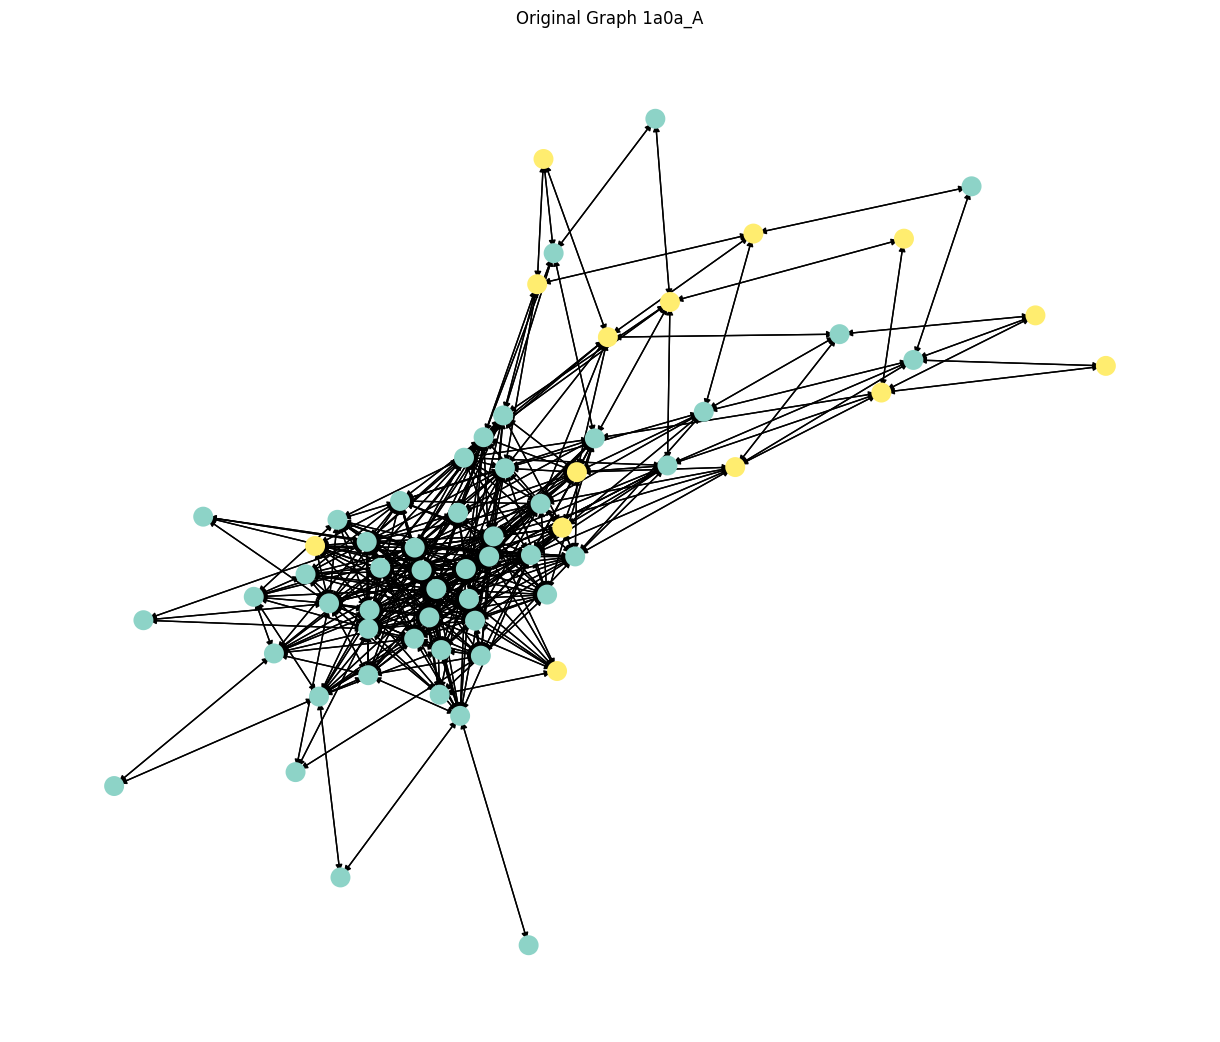

In [21]:
vis = to_networkx(data)
node_labels = data.y.numpy()
plt.figure(1,figsize=(12,10)) 
nx.draw(vis, cmap=plt.get_cmap('Set3'),node_color = node_labels,node_size=70,linewidths=6)
plt.title(f'Original Graph {dataset.targets[0]}')
plt.show()

In [22]:
#test with egnn model
torch.manual_seed(1231)
egnn = eg.EGNN(in_node_nf=data.x.shape[1], hidden_nf=1028, out_node_nf=1, in_edge_nf=1)
criterion = torch.nn.BCELoss()
h, x = egnn(data.x, data.pos, data.edge_index, data.edge_attr)
pred = torch.nn.Sigmoid()(h)
l1_loss = criterion(pred, data.y)
print(f'loss:{l1_loss.item()}')

loss:0.6366453170776367


In [23]:
#evaluation
pred = pred.squeeze()
pred = torch.tensor([0 if each<0.5 else 1 for each in pred], dtype=torch.int32)
y_int = data.y.to(torch.int64)
y_int = y_int.squeeze()
t_p = ((pred == 1) & (y_int == 1)).sum()
t_n = ((pred == 0) & (y_int == 0)).sum()
actual_p = (y_int == 1).sum()
t_p, t_n, actual_p


(tensor(4), tensor(43), tensor(14))

In [24]:
y_int, pred

(tensor([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=torch.int32))

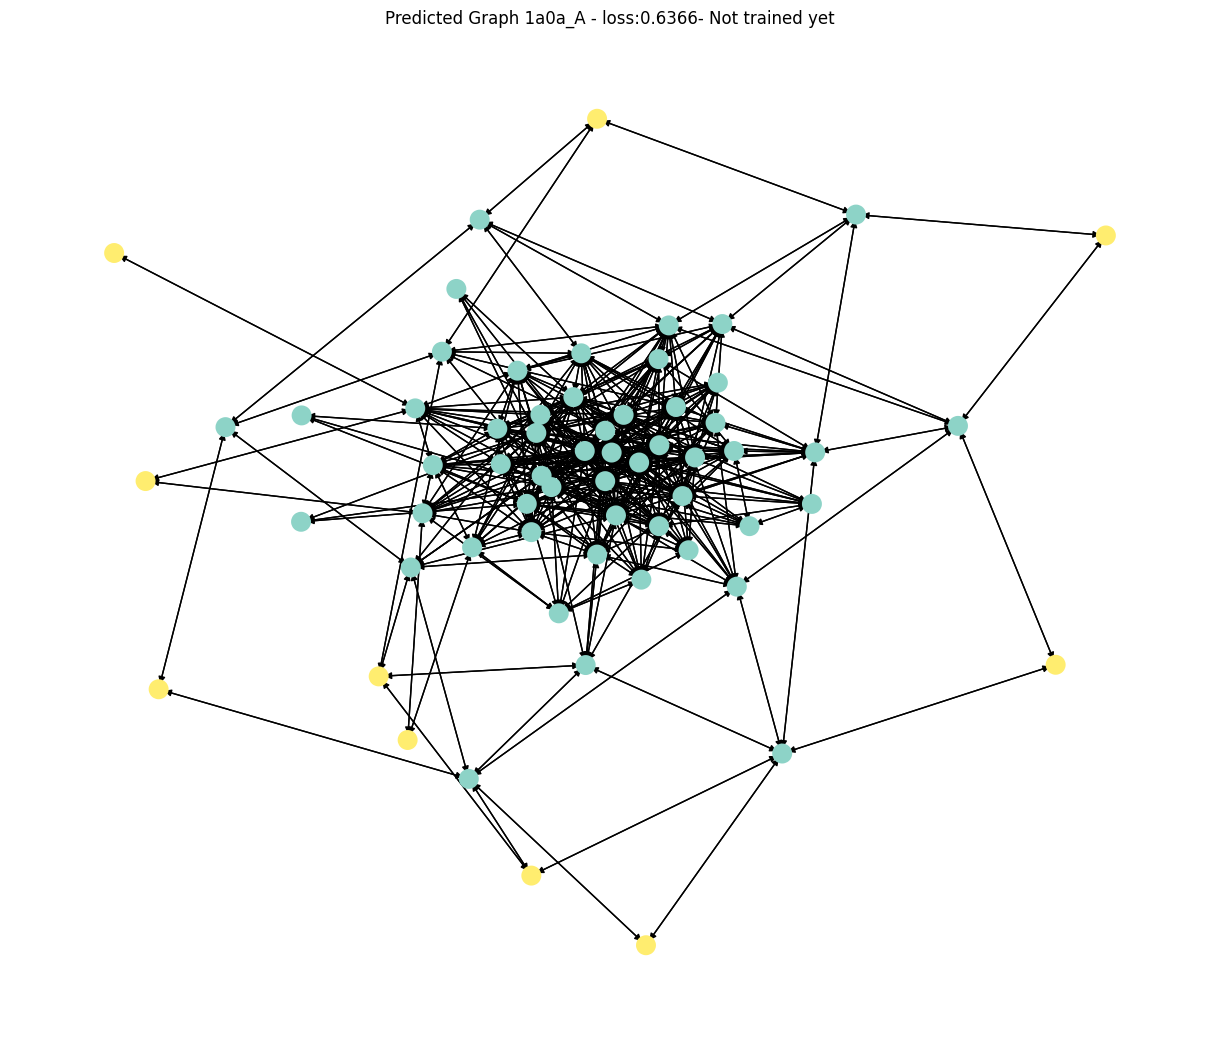

In [28]:
pred_y  = pred.unsqueeze(dim=1)
graph_pred = Data(x=data.x, edge_index=data.edge_index, edge_attr=data.edge_attr, pos=data.pos, y=pred_y)
vis = to_networkx(graph_pred)

node_labels = pred_y.numpy()


plt.figure(1,figsize=(12,10)) 
nx.draw(vis, cmap=plt.get_cmap('Set3'),node_color = node_labels,node_size=70,linewidths=6)
plt.title(f'Predicted Graph {dataset.targets[0]} - loss:{l1_loss.item():.4f}- Not trained yet')
plt.show()